In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
!pip install transformers
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

In [2]:
path  = '/content/drive/MyDrive/Projects/HDA Proj/mini_dataset'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class OCTDataLoader:
    def __init__(self, data_dir, img_size=(224, 224), batch_size=1024):
        self.data_dir = data_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.test_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def get_loaders(self):
        # Load train and test datasets with appropriate transformations
        try:
            train_dataset = datasets.ImageFolder(f'{self.data_dir}/train', transform=self.train_transform)
            test_dataset = datasets.ImageFolder(f'{self.data_dir}/test', transform=self.test_transform)
        except FileNotFoundError as e:
            print("Error: One of the required directories or files is missing.")
            raise e

        # Create data loaders for training and testing
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)

        return train_loader, test_loader

In [5]:
# Usage example
data_loader = OCTDataLoader(data_dir=path, img_size=(224, 224), batch_size=64)
train_loader, test_loader = data_loader.get_loaders()

In [6]:
import torch
import time
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import numpy as np

class ViTTrainer:
    def __init__(self, train_loader, test_loader=None, num_classes=4, lr=2e-5, epochs=5, device=None):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epochs = epochs
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize model, optimizer, and loss function
        self.model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224-in21k",
            num_labels=num_classes
        ).to(self.device)

        self.optimizer = AdamW(self.model.parameters(), lr=lr)
        self.criterion = CrossEntropyLoss()

        # Lists to track loss and accuracy
        self.train_losses = []
        self.train_accuracies = []
        self.epoch_times = []

    def train(self):
        for epoch in range(self.epochs):
            start_time = time.time()
            epoch_loss, epoch_accuracy = self.train_epoch()
            epoch_time = time.time() - start_time

            self.train_losses.append(epoch_loss)
            self.train_accuracies.append(epoch_accuracy)
            self.epoch_times.append(epoch_time)

            print(f"\nEpoch {epoch + 1}/{self.epochs}")
            print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Time: {epoch_time:.2f}s")

            # Plot the metrics at each epoch
            self.plot_metrics()

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        # Progress bar
        progress_bar = tqdm(self.train_loader, desc="Training", leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(self.device), labels.to(self.device)

            # Forward pass
            outputs = self.model(images).logits
            loss = self.criterion(outputs, labels)

            # Backward pass and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Track loss and accuracy
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Calculate metrics for this batch
            batch_loss = loss.item()
            batch_accuracy = correct / total

            # Update the progress bar with current loss and accuracy
            progress_bar.set_postfix({"Loss": batch_loss, "Accuracy": batch_accuracy * 100})

        avg_loss = total_loss / len(self.train_loader)
        accuracy = correct / total
        return avg_loss, accuracy

    def plot_metrics(self):
        epochs_range = range(1, len(self.train_losses) + 1)

        # Plot Loss
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.train_losses, marker='o', color='blue')
        plt.title("Train Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.grid(True)

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, np.array(self.train_accuracies) * 100, marker='o', color='green')
        plt.title("Train Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy (%)")
        plt.grid(True)

        plt.tight_layout()
        plt.show()

In [7]:
# Instantiate the trainer with train and test data loaders
trainer = ViTTrainer(train_loader=train_loader, test_loader=test_loader, num_classes=4, lr=2e-5, epochs=3)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
Train Loss: 0.6544, Train Accuracy: 0.8098, Time: 1599.30s


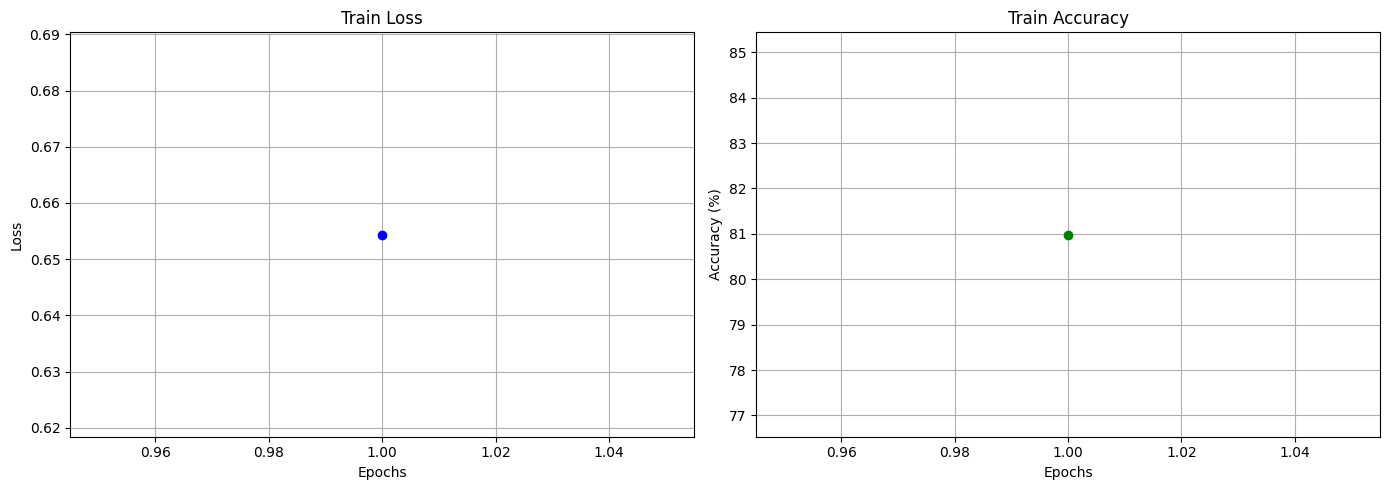


Epoch 2/3
Train Loss: 0.2786, Train Accuracy: 0.9282, Time: 256.45s


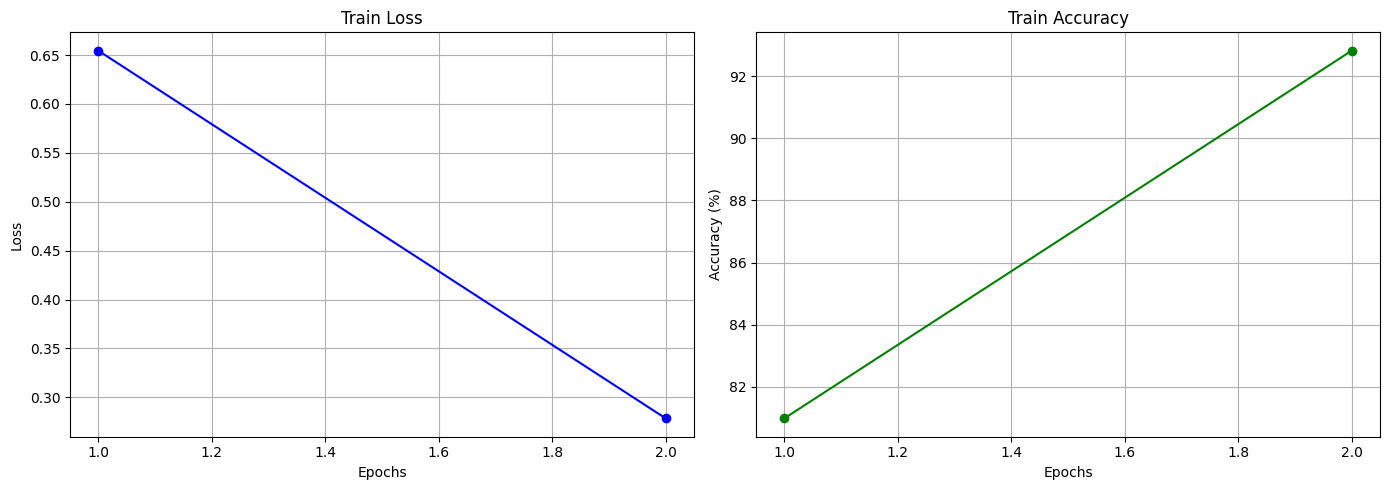


Epoch 3/3
Train Loss: 0.2203, Train Accuracy: 0.9396, Time: 264.16s


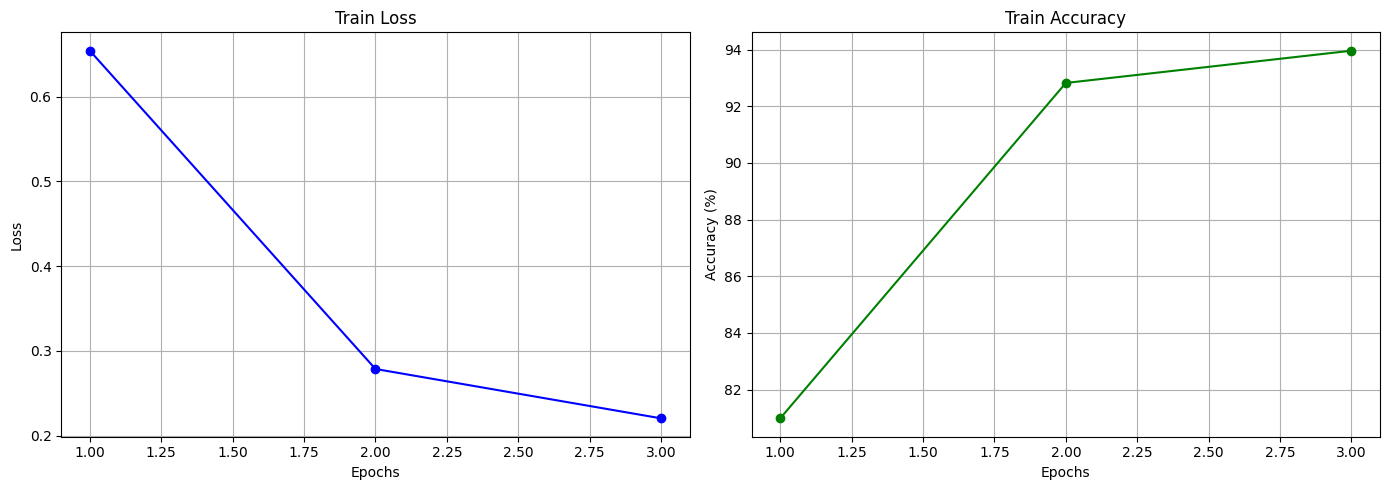

In [8]:
# Train the model
trainer.train()

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns

class Evaluation:
    def __init__(self, model, test_loader, device=None):
        self.model = model
        self.test_loader = test_loader
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def evaluate(self):
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                # Get predictions
                outputs = self.model(images).logits
                _, preds = torch.max(outputs, 1)

                # Store predictions and true labels
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Convert lists to numpy arrays
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Print the metrics
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test Precision (Weighted): {precision:.4f}")
        print(f"Test Recall (Weighted): {recall:.4f}")
        print(f"Test F1 Score (Weighted): {f1:.4f}")

        # Plot Confusion Matrix
        self.plot_confusion_matrix(all_labels, all_preds)

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["CNV", "Drusen", "Normal", "DME"], yticklabels=["CNV", "Drusen", "Normal", "DME"])
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


Test Accuracy: 0.9800
Test Precision (Weighted): 0.9815
Test Recall (Weighted): 0.9800
Test F1 Score (Weighted): 0.9802


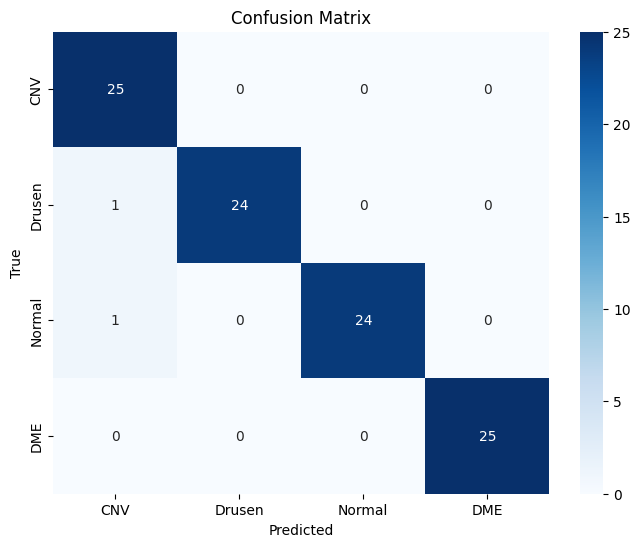

In [12]:
# Instantiate the evaluator with the trained model and test data loader
evaluator = Evaluation(model=trainer.model, test_loader=test_loader)

# Evaluate the model on the test set
evaluator.evaluate()


In [13]:
# Save the trained model after training
model_save_path = "vit_oct_mini_model.pth"
torch.save(trainer.model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to vit_oct_mini_model.pth


##Predict

In [14]:
from transformers import ViTForImageClassification
import torch
from PIL import Image
from torchvision import transforms

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k", num_labels=4
)
model.load_state_dict(torch.load("/content/vit_oct_mini_model.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Function to preprocess the image
def preprocess_image(image_path, img_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to predict the class
def predict_image(image, model):
    with torch.no_grad():
        outputs = model(image)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-8db459045d81>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

In [18]:
# Example usage
image_path = "/content/drive/MyDrive/Projects/HDA Proj/test/NORMAL/NORMAL-12494-2.jpeg"  # Replace with actual image path
image = preprocess_image(image_path)
image = image.to(device)

# Make prediction
predicted_class = predict_image(image, model)

# Map class index to class label
class_labels = ["CNV", "DME", "Drusen", "Normal"]
predicted_label = class_labels[predicted_class]
print(f"Predicted label: {predicted_label}")


Predicted label: Normal


In [27]:
import shutil

# Define the model save path in Google Drive
drive_model_path = '/content/drive/MyDrive/Projects/HDA Proj/models/vit_oct_mini_model.pth'

# Copy the model file to Google Drive
shutil.copy('/content/vit_oct_mini_model.pth', drive_model_path)

print(f"Model copied to Google Drive at {drive_model_path}")



Model copied to Google Drive at /content/drive/MyDrive/Projects/HDA Proj/models/vit_oct_mini_model.pth
